# Amplitude model with `ampform`

Formulate helicity amplitude model for $p \gamma \to \eta \pi^0 p$ symbolically using [AmpForm](https://ampform.rtfd.io).

In [1]:
import logging
import os
import warnings
from collections import defaultdict

import ampform
import graphviz
import ipywidgets as w
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import qrules
import sympy as sp
from ampform.dynamics.builder import RelativisticBreitWignerBuilder
from ampform.io import aslatex, improve_latex_rendering
from IPython.display import SVG, Image, Math, display
from qrules.particle import Particle, Spin, create_particle, load_pdg
from tensorwaves.data import (
    SympyDataTransformer,
    TFPhaseSpaceGenerator,
    TFUniformRealNumberGenerator,
)
from tensorwaves.function.sympy import create_parametrized_function

STATIC_PAGE = "EXECUTE_NB" in os.environ

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.disable(logging.WARNING)
warnings.filterwarnings("ignore")

improve_latex_rendering()
particle_db = load_pdg()

## Generate transitions

In [2]:
pgamma1 = Particle(
    name="pgamma1",
    latex=r"p\gamma (s1/2)",
    spin=0.5,
    mass=4.101931071854584,
    charge=1,
    isospin=Spin(1 / 2, +1 / 2),
    baryon_number=1,
    parity=-1,
    pid=99990,
)
pgamma2 = create_particle(
    template_particle=pgamma1,
    name="pgamma2",
    latex=R"p\gamma (s3/2)",
    spin=1.5,
    pid=pgamma1.pid + 1,
)
particle_db.update([pgamma1, pgamma2])

We keep the relevant information about branching fractions in the previous [Branching fraction](../branching-fraction.md) chapter.
For simplicity, after the information about branching fraction, and under the current `qrules` results, we limit the intermediate resonances to be:

- $a(2)$ for $\eta \pi^0$, 
- $\Delta(1232)$ for $\pi p$",
- and "$N(1535)$" for both $\pi^0 p$ and $\eta p$.

In [3]:
reaction = qrules.generate_transitions(
    initial_state="pgamma1",
    final_state=["eta", "pi0", "p"],
    allowed_intermediate_particles=["a(2)(1320)", "N(1535)", "Delta(1232)"],
    allowed_interaction_types=["strong", "EM"],
    particle_db=particle_db,
    max_angular_momentum=3,
    max_spin_magnitude=3,
    mass_conservation_factor=0,
)

Propagating quantum numbers:   0%|          | 0/48 [00:00<?, ?it/s]

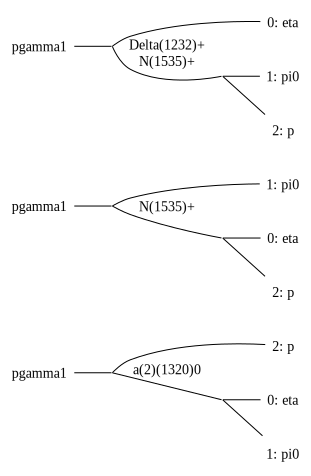

In [4]:
src = qrules.io.asdot(reaction, collapse_graphs=True)
graphviz.Source(src)

## Formulate model

In [5]:
model_builder = ampform.get_builder(reaction)
model_builder.config.scalar_initial_state_mass = True
model_builder.config.stable_final_state_ids = 0, 1, 2
bw_builder = RelativisticBreitWignerBuilder(
    energy_dependent_width=False,
    form_factor=False,
)
for name in reaction.get_intermediate_particles().names:
    model_builder.dynamics.assign(name, bw_builder)
model = model_builder.formulate()

The first component of the full amplitude is shown below.
The other terms are in similar way of formualation and thus not showing explicitly here again.

In [6]:
(symbol, expr), *_ = model.amplitudes.items()
Math(aslatex({symbol: expr}, terms_per_line=1))

<IPython.core.display.Math object>

In [7]:
sorted_parameter_defaults = {
    symbol: model.parameter_defaults[symbol]
    for symbol in sorted(model.parameter_defaults, key=str)
}
src = aslatex(sorted_parameter_defaults)
Math(src)

<IPython.core.display.Math object>

In [8]:
Math(aslatex(model.kinematic_variables))

<IPython.core.display.Math object>

## Visualization

In [9]:
unfolded_expression = model.expression.doit()
intensity_func = create_parametrized_function(
    expression=unfolded_expression,
    parameters=model.parameter_defaults,
    backend="jax",
)

In [10]:
phsp_event = 500_000
rng = TFUniformRealNumberGenerator(seed=0)
phsp_generator = TFPhaseSpaceGenerator(
    initial_state_mass=reaction.initial_state[-1].mass,
    final_state_masses={i: p.mass for i, p in reaction.final_state.items()},
)
phsp_momenta = phsp_generator.generate(phsp_event, rng)

Generating phase space sample:   0%|          | 0/500000 [00:00<?, ?it/s]

I0000 00:00:1764006412.386857 28626569 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [11]:
helicity_transformer = SympyDataTransformer.from_sympy(
    model.kinematic_variables,
    backend="jax",
)
phsp = helicity_transformer(phsp_momenta)

In [12]:
resonances = defaultdict(set)
for transition in reaction.transitions:
    topology = transition.topology
    top_decay_products = topology.get_edge_ids_outgoing_from_node(0)
    (resonance_id, resonance), *_ = transition.intermediate_states.items()
    recoil_id, *_ = top_decay_products - {resonance_id}
    resonances[recoil_id].add(resonance.particle)
resonances = {k: sorted(v, key=lambda p: p.mass) for k, v in resonances.items()}
{k: [p.name for p in v] for k, v in resonances.items()}

{0: ['Delta(1232)+', 'N(1535)+'], 1: ['N(1535)+'], 2: ['a(2)(1320)0']}

In [13]:
sliders = {}
categorized_sliders_m = defaultdict(list)
categorized_sliders_gamma = defaultdict(list)
categorized_cphi_pair = defaultdict(list)

for symbol, value in model.parameter_defaults.items():
    if symbol.name.startswith(R"\Gamma_{"):
        slider = w.FloatSlider(
            description=Rf"\({sp.latex(symbol)}\)",
            min=0.0,
            max=1.0,
            step=0.01,
            value=value,
            continuous_update=False,
        )
        sliders[symbol.name] = slider
        if symbol.name.startswith(R"\Gamma_{N"):
            categorized_sliders_gamma[0].append(slider)
        elif symbol.name.startswith(R"\Gamma_{\D"):
            categorized_sliders_gamma[1].append(slider)
        elif symbol.name.startswith(R"\Gamma_{a"):
            categorized_sliders_gamma[2].append(slider)

    if symbol.name.startswith("m_{"):
        slider = w.FloatSlider(
            description=Rf"\({sp.latex(symbol)}\)",
            min=0.63,
            max=4,
            step=0.01,
            value=value,
            continuous_update=False,
        )
        sliders[symbol.name] = slider
        if symbol.name.startswith("m_{N"):
            categorized_sliders_m[0].append(slider)
        elif symbol.name.startswith(R"m_{\D"):
            categorized_sliders_m[1].append(slider)
        elif symbol.name.startswith("m_{a"):
            categorized_sliders_m[2].append(slider)

    if symbol.name.startswith("C_{"):
        c_latex = sp.latex(symbol)
        phi_latex = c_latex.replace("C", R"\phi", 1)

        slider_c = w.FloatSlider(
            description=Rf"\({c_latex}\)",
            min=0,
            max=10,
            step=0.01,
            value=abs(value),
            continuous_update=False,
        )
        slider_phi = w.FloatSlider(
            description=Rf"\({phi_latex}\)",
            min=-np.pi,
            max=+np.pi,
            step=0.01,
            value=np.angle(value),
            continuous_update=False,
        )

        sliders[symbol.name] = slider_c
        sliders[symbol.name.replace("C", "phi", 1)] = slider_phi

        cphi_hbox = w.HBox([slider_c, slider_phi])
        if R"\D" in symbol.name:
            categorized_cphi_pair[1].append(cphi_hbox)
        elif "N" in symbol.name:
            categorized_cphi_pair[0].append(cphi_hbox)
        elif "a" in symbol.name:
            categorized_cphi_pair[2].append(cphi_hbox)

tab_contents = []
resonances_name = ["N*", "Δ*", "a₂*"]
for i in range(len(resonances_name)):
    tab_content = w.VBox([
        w.HBox(categorized_sliders_m[i] + categorized_sliders_gamma[i]),
        w.VBox(categorized_cphi_pair[i]),
    ])
    tab_contents.append(tab_content)
UI = w.Tab(tab_contents, titles=resonances_name)

In [14]:
def insert_phi(parameters: dict) -> dict:
    updated_parameters = {}
    for key, value in parameters.items():
        if key.startswith("phi_"):
            continue
        if key.startswith("C_"):
            phi_key = key.replace("C_", "phi_")
            if phi_key in parameters:
                phi = parameters[phi_key]
                value *= np.exp(1j * phi)  # noqa:PLW2901
        updated_parameters[key] = value
    return updated_parameters

In [15]:
%matplotlib widget

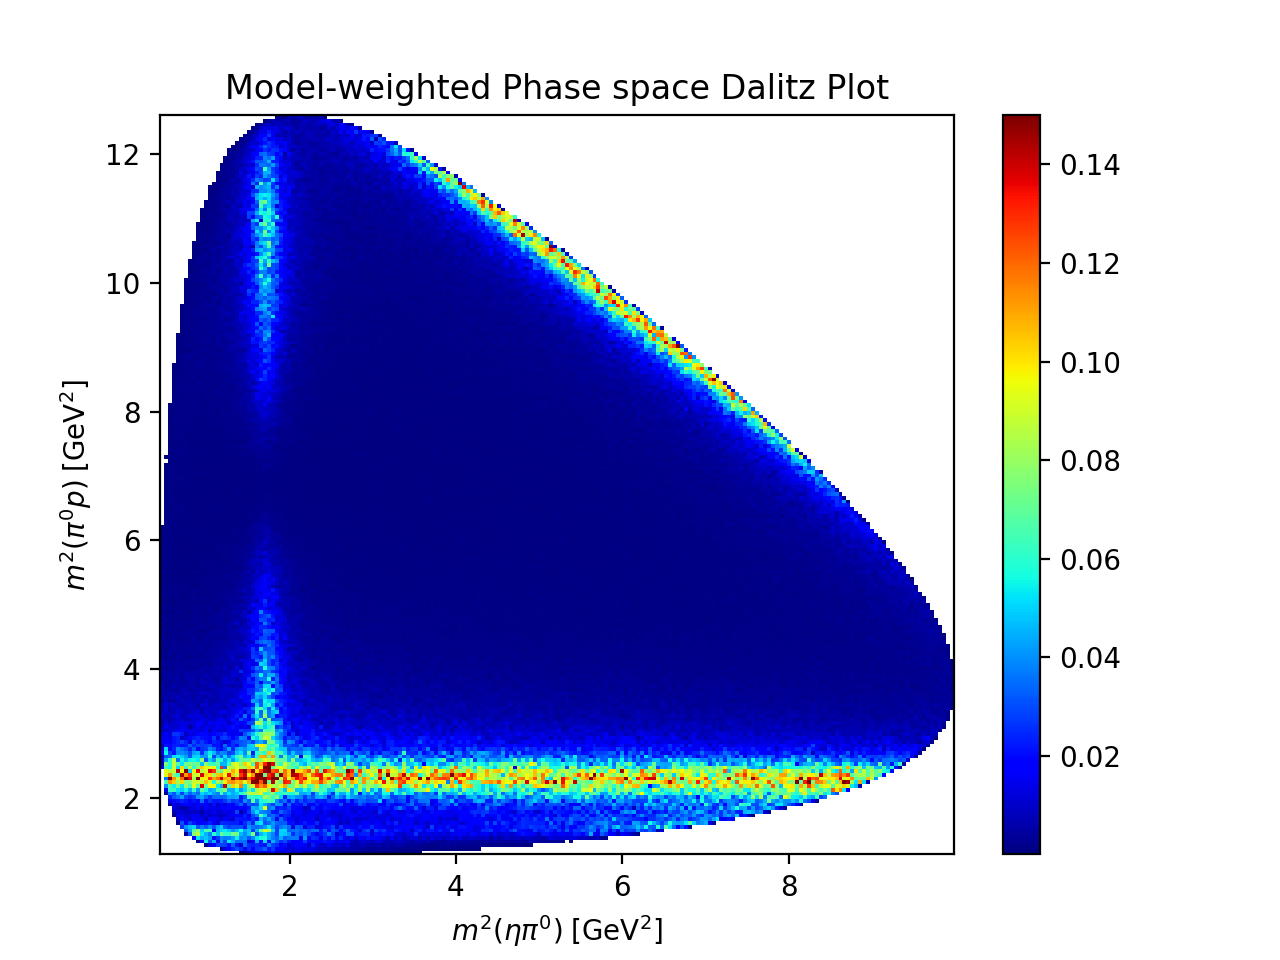

In [16]:
fig_2d, ax_2d = plt.subplots(dpi=200)
ax_2d.set_title("Model-weighted Phase space Dalitz Plot")
ax_2d.set_xlabel(R"$m^2(\eta \pi^0)\;\left[\mathrm{GeV}^2\right]$")
ax_2d.set_ylabel(R"$m^2(\pi^0 p)\;\left[\mathrm{GeV}^2\right]$")
fig_2d.canvas.toolbar_visible = False
fig_2d.canvas.header_visible = False
fig_2d.canvas.footer_visible = False

mesh = None


def update_histogram(**parameters):
    global mesh
    parameters = insert_phi(parameters)
    intensity_func.update_parameters(parameters)
    intensity_weights = intensity_func(phsp)
    bin_values, xedges, yedges = jnp.histogram2d(
        phsp["m_01"].real ** 2,
        phsp["m_12"].real ** 2,
        bins=200,
        weights=intensity_weights,
        density=True,
    )
    bin_values = jnp.where(bin_values < 1e-6, jnp.nan, bin_values)
    x, y = jnp.meshgrid(xedges[:-1], yedges[:-1])
    if mesh is None:
        mesh = ax_2d.pcolormesh(x, y, bin_values.T, cmap="jet", vmax=0.15)
    else:
        mesh.set_array(bin_values.T)
    fig_2d.canvas.draw()


w.interactive_output(update_histogram, sliders)
fig_2d.colorbar(mesh, ax=ax_2d)

if STATIC_PAGE:
    filename = "dalitz-plot-auto.png"
    fig_2d.savefig(filename)
    plt.close(fig_2d)
    display(UI, Image(filename))
else:
    display(UI, fig_2d.canvas)

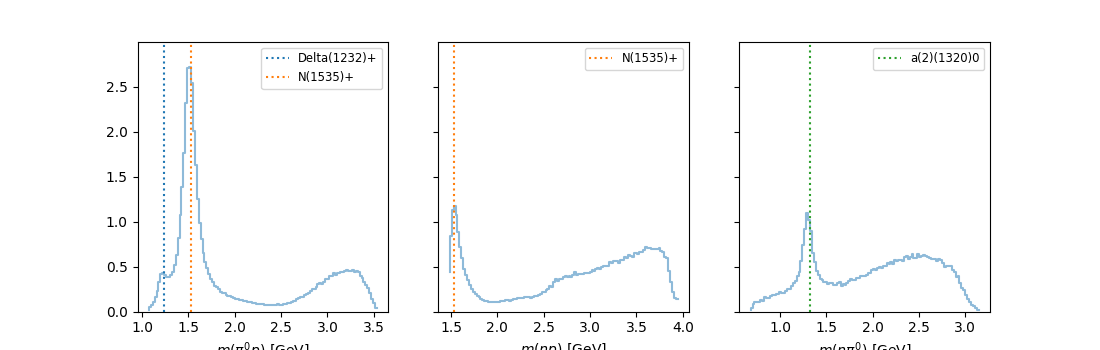

In [17]:
fig, axes = plt.subplots(figsize=(11, 3.5), ncols=3, sharey=True)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
ax1, ax2, ax3 = axes

for recoil_id, ax in enumerate(axes):
    decay_products = sorted({0, 1, 2} - {recoil_id})
    product_latex = " ".join([reaction.final_state[i].latex for i in decay_products])
    ax.set_xlabel(f"$m({product_latex})$ [GeV]")

LINES = 3 * [None]
RESONANCE_LINES = defaultdict(dict)


def update_plot(**parameters):
    parameters = insert_phi(parameters)
    intensity_func.update_parameters(parameters)
    intensities = intensity_func(phsp)
    max_value = 0
    resonance_colors: dict[Particle, int] = {}
    color_id = 0
    for recoil_id, ax in enumerate(axes):
        decay_products = sorted({0, 1, 2} - {recoil_id})
        key = f"m_{''.join(str(i) for i in decay_products)}"
        bin_values, bin_edges = jax.numpy.histogram(
            phsp[key].real,
            bins=120,
            density=True,
            weights=intensities,
        )
        max_value = max(max_value, bin_values.max())

        if LINES[recoil_id] is None:
            LINES[recoil_id] = ax.step(bin_edges[:-1], bin_values, alpha=0.5)[0]
        else:
            LINES[recoil_id].set_ydata(bin_values)

        for resonance in resonances[recoil_id]:
            key = f"m_{{{resonance.latex}}}"
            val = parameters.get(key, resonance.mass)
            resonance_line = RESONANCE_LINES[recoil_id].get(resonance.name)
            if resonance_line is None:
                RESONANCE_LINES[recoil_id][resonance.name] = ax.axvline(
                    val,
                    c=f"C{resonance_colors.get(resonance, color_id)}",
                    ls="dotted",
                    label=resonance.name,
                )
            else:
                resonance_line.set_xdata([val, val])
            if resonance not in resonance_colors:
                resonance_colors[resonance] = color_id
                color_id += 1

    for ax in axes:
        ax.set_ylim(0, max_value * 1.1)


w.interactive_output(update_plot, sliders)
for ax in axes:
    ax.legend(fontsize="small")

if STATIC_PAGE:
    filename = "1d-histograms-auto.svg"
    fig.savefig(filename)
    plt.close(fig)
    display(UI, SVG(filename))
else:
    display(UI, fig.canvas)